In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from collections import defaultdict

from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn

import torch_geometric
from torch_geometric.data import Data

sns.set(font_scale=1.3)

In [4]:
targets = pd.read_csv('./data/FINAL_TARGETS_DATES_TRAINTEST.tsv', sep='\t')
features = pd.read_csv('./data/FINAL_FEATURES_TRAINTEST.tsv', sep='\t')
all_sequences = pd.read_csv('./data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv', sep='\t')
sequences_matrix = pd.read_csv('./data/FINAL_SEQUENCES_MATRIX.tsv', sep='\t')
friends = pd.read_csv('./data/FINAL_FEATURES_FRIENDS.tsv', sep='\t', nrows=10 ** 5)

In [5]:
all_sequences

,CLIENT_ID,SEQUENCE
0,1000100,"['e84b0f471b8e8f4aecc81eb27b16c092', '9a7670be..."
1,1000121,"['9804a8d70c5e8c26830bdafe2c2db49c', '9ca02fb0..."
2,1000131,"['b496d19eb25556bd64e481d11b6f7dd6', 'eb727f97..."
3,1000132,"['467a38fe36ef666e264823387f66f3c8', 'e0494409..."
4,100013,"['b496d19eb25556bd64e481d11b6f7dd6', 'fc18cab3..."
...,...,...
123702,999735,"['c734cde7f7ab57d48debbd587f4cf126', 'fdc759e2..."
123703,999783,"['1669b50f343dd2e888c2ef6e2a218b23', '27317357..."
123704,99978,"['5f82488fb41f39bb377b55eb85837dba', '6d69d039..."
123705,999791,"['6a59be6dae2918aa5a0d79ac0cbc39ef', 'dcfd13a9..."


In [4]:
targets

,CLIENT_ID,RETRO_DT,TARGET
0,1011725,20210501,0
1,1018784,20210501,1
2,1021812,20210501,0
3,1024003,20210501,0
4,1025140,20210501,test
...,...,...,...
159285,72633,20210731,0
159286,72634,20210731,1
159287,72641,20210731,0
159288,72642,20210731,test


In [5]:
features

,CLIENT_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,i1067,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,7150,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7154,0.0,16.0,156.0,0.0,0.0,20.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7156,0.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26966,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26993,0.0,27.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159283,1770013,0.0,0.0,52.0,0.0,0.0,2.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159284,1770014,0.0,0.0,27.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159285,1770023,0.0,0.0,27.0,0.0,0.0,9.0,23.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159286,1770038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
friends

,CLIENT_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,i1067,...,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9,FRIEND_ID
0,999819,0.0,0.0,8.0,1.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99981973
1,999819,0.0,45.0,41.0,0.0,18.0,2.0,17.0,0.0,6.0,...,0.0,29.0,0.0,0.0,133.0,0.0,0.0,0.0,0.0,99981949
2,999819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99981979
3,999819,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99981939
4,999819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99981975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,83231,0.0,3.0,240.0,2.0,5.0,9.0,210.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8323156
99996,83231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8323162
99997,83231,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8323113
99998,83231,0.0,0.0,24.0,0.0,0.0,4.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8323100


In [14]:
all_sequences

,CLIENT_ID,SEQUENCE
0,1000100,"['e84b0f471b8e8f4aecc81eb27b16c092', '9a7670be..."
1,1000121,"['9804a8d70c5e8c26830bdafe2c2db49c', '9ca02fb0..."
2,1000131,"['b496d19eb25556bd64e481d11b6f7dd6', 'eb727f97..."
3,1000132,"['467a38fe36ef666e264823387f66f3c8', 'e0494409..."
4,100013,"['b496d19eb25556bd64e481d11b6f7dd6', 'fc18cab3..."
...,...,...
123702,999735,"['c734cde7f7ab57d48debbd587f4cf126', 'fdc759e2..."
123703,999783,"['1669b50f343dd2e888c2ef6e2a218b23', '27317357..."
123704,99978,"['5f82488fb41f39bb377b55eb85837dba', '6d69d039..."
123705,999791,"['6a59be6dae2918aa5a0d79ac0cbc39ef', 'dcfd13a9..."


In [15]:
sequences_matrix

,SESSIONS_SEQUENCES
0,"['68a9902529901882ecd5143460468d4c', '79d75347..."
1,['72b88f72bca2636844bb14b9cd9e29b3']
2,"['b496d19eb25556bd64e481d11b6f7dd6', 'd21918bb..."
3,"['dcb3d50673073d3c023db102f21b2d3e', '09a5d816..."
4,"['3de59e26ee7e94a6ccd0a2eead2fab9a', '4a51f13a..."
...,...
1489571,['af718335cce0487a7d3b1ae64eb58c32']
1489572,['2d94c9bf487950e65f6f999ced39c116']
1489573,['21ab3e195efa4fca5a52a3d9b9eb0253']
1489574,"['f4d6ee901e5217b0f54350ae716451c2', 'f945d74b..."


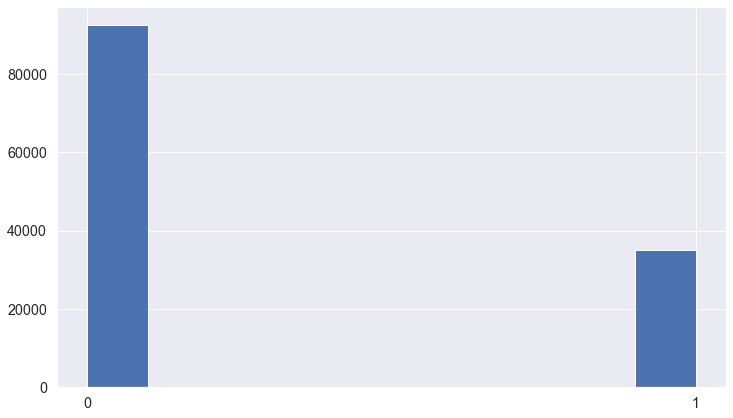

In [16]:
plt.figure(figsize=(12, 7))
plt.hist(targets[targets['TARGET'] != 'test']['TARGET'])
plt.show()

In [7]:
clients = np.load('./data/CLIENT_ID.npy')
friends_ = np.load('./data/FRIEND_ID.npy')

In [8]:
client_in = []
for client in tqdm(clients):
    client_in.append(client in features['CLIENT_ID'])
    
client_in = np.array(client_in)

  0%|          | 0/9974289 [00:00<?, ?it/s]

In [9]:
filtered_idx = np.where(client_in)[0]

In [10]:
friend_in = []
for friend in tqdm(friends_):
    friend_in.append(friend in features['CLIENT_ID'])
    
friend_in = np.array(friend_in)

  0%|          | 0/9974289 [00:00<?, ?it/s]

In [21]:
friend_in.sum()

0

In [22]:
with open('important_feat.pickle', 'rb') as handle:
    important_features = pickle.load(handle)

In [25]:
idx = []
for feature in important_features:
    idx.append(np.where(friends.columns.values[1:-1] == feature)[0][0])
    
idx.sort()
idx = [0] + idx + [friends.shape[1] - 1]

In [11]:
compressed = []
curr_idx = 0
with open('./data/FINAL_FEATURES_FRIENDS.tsv') as f:
    for i, line in tqdm(enumerate(f), total=len(friend_in)):
        if i == 0 or i - 1 != filtered_idx[curr_idx]:
            continue
        s = line.strip().split('\t')
        compressed.append(s)
        curr_idx += 1
        break
        if curr_idx == len(filtered_idx):
            break
        
compressed = np.array(compressed)

  0%|          | 0/9974289 [00:00<?, ?it/s]

In [31]:
np.save('compressed.npy', compressed)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])